# `fMRI-06`: First-level analysis
In this notebook, we demonstrate a full first-level regression analysis (often referred to as the general linear model or GLM) on volumetric fMRI data preprocessed using fMRIPrep

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

### Step 1: Generate block design regressors

In the first step, we construct the design matrix based on the fMRI task. Here we are analyzing a simple visual experiment using a flickering checkerboard to evoke responses in early visual cortex. We presented six blocks of a rotating visual checkerboard (20 s duration) to one participant. The total run is 250 volumes and the repetition time (TR) was 1 s.

In [4]:
events = read_csv(events_f, sep='\t')

In [5]:
events

,onset,duration,event
0,0.0136,10.0,Fixation cross
1,10.0143,20.0,Checkerboard
2,30.0313,20.0,Fixation cross
3,50.0315,20.0,Checkerboard
4,70.0612,20.0,Fixation cross
5,90.0614,20.0,Checkerboard
6,110.0801,20.0,Fixation cross
7,130.0803,20.0,Checkerboard
8,150.0981,20.0,Fixation cross
9,170.0982,20.0,Checkerboard


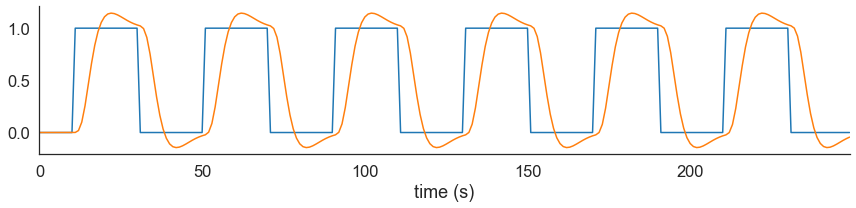

In [2]:
from pandas import read_csv
from fmritools.design import design_matrix

# Define some acquisition parameters
n_acq = 250
tr = 1

# Load experimental events
events_f = 'sub-01_task-visualcontrol_desc-events.tsv'
events = read_csv(events_f, sep='\t')

# Limit only to checkerboard events
events = events.query('event=="Checkerboard"')
events.event = 1

# Compute offsets (onset + duration)
events['offset'] = events['onset'].values + events['duration'].values

# Construct events matrix
events = events[['onset','offset','event']].values

# Define design matrix
times, X, boxcars = design_matrix(tr, n_acq, events, return_boxcars=True)

# Plot boxcars
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(times, boxcars)
ax.plot(times, X)
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)')
sns.despine()
plt.tight_layout()

### Step 2: Prepare confound regressors

In this next section, we prepare a handful of confound (or "nuisance") regressors. These variables are not of experimental interest, but are included so as to account for variance introduced by head motion, physiological fluctuations, etc.

#### Motion regressors

We prepare six motion parameters (X/Y/Z-translation, pitch/yaw/roll-rotation) returned by fMRIPrep's volume registration algorithm.

In [7]:
confounds

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor05,Cosine00,Cosine01,NonSteadyStateOutlier00,X,Y,Z,RotX,RotY,RotZ
0,253.234604,18.247177,110.129547,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000e+00,0.000000,0.000000,0.000000,-0.000000,-0.000170
1,124.324738,8.198837,50.530537,1.403284,23.978643,1.296899,0.097453,0.158814,-0.040158,0.024319,...,0.304260,0.089620,0.089615,0.0,2.599910e-03,-0.026813,0.045403,0.000282,-0.000000,0.000000
2,76.789871,6.641218,14.968636,1.278825,21.851946,1.152606,0.088018,0.084312,0.095566,0.066093,...,0.227906,0.089606,0.089558,0.0,0.000000e+00,-0.054855,0.068672,0.000965,-0.000000,0.000000
3,34.201775,-0.937883,2.568844,1.245354,21.280008,1.109035,0.123503,0.083555,0.007169,-0.046758,...,0.189108,0.089578,0.089444,0.0,1.013690e-09,0.028482,0.062744,0.000280,-0.000000,0.000000
4,-3.725674,-3.740618,5.686630,1.104751,18.877462,1.012719,0.071523,0.096497,-0.075871,0.044696,...,0.148186,0.089535,0.089273,0.0,0.000000e+00,0.063000,0.044457,-0.000095,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,39.666103,15.768450,75.504776,1.193003,20.385460,1.064945,0.057477,-0.113517,-0.081595,0.126806,...,0.032963,-0.089478,0.089045,0.0,2.687570e-03,-0.136018,0.400518,0.006803,0.000955,0.000646
246,50.457893,32.112198,63.907719,1.229910,21.016115,1.089294,0.160290,-0.092367,-0.067080,0.021058,...,-0.013189,-0.089535,0.089273,0.0,4.370500e-03,-0.055453,0.376661,0.005776,0.000955,0.000589
247,54.804859,34.680069,35.432732,1.143729,19.543499,1.053545,0.083130,-0.022016,-0.078564,-0.005681,...,0.027076,-0.089578,0.089444,0.0,-2.312860e-03,-0.096599,0.395373,0.005569,0.000898,0.000522
248,49.427216,25.373917,-6.058857,1.301626,22.241570,1.157619,0.222051,0.050701,-0.043135,0.005861,...,0.041131,-0.089606,0.089558,0.0,-4.356730e-03,-0.179710,0.449467,0.006778,0.000643,0.000714


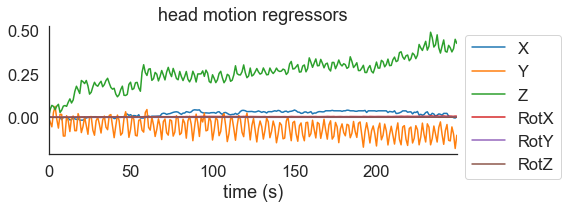

In [8]:
# Load fMRIPrep confound regressors
confounds_f = 'sub-01_task-visualcontrol_desc-confounds_regressors.tsv'
confounds = read_csv(confounds_f, sep='\t')

# Extract motion regressors
motion_labels = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
motion = confounds[motion_labels].values

# Visualize motion regressors
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, motion, label=motion_labels)
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)', 
       title='head motion regressors')
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

#### Motion censoring

We prepare the motion censoring time series (or "motion scrubbers") from the framewise displacement estimates returned by fMRIPrep. Motion censoring is intended to absorb the variance from volumes "infected" with large head motion.

0 bad volumes detected


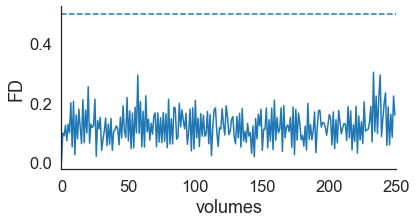

In [4]:
# Define FD threshold
fd_threshold = 0.5

# Extract framewise displacement from confounds table
fd = confounds['FramewiseDisplacement'].values
fd[np.isnan(fd)] = 0

# Identify infected volumes
bad_vols = np.argwhere(fd >= fd_threshold)
print(f'{bad_vols.size} bad volumes detected')

# Construct censor regressors
censors = np.zeros((fd.shape[0], bad_vols.shape[0]))
censors[bad_vols.T, np.arange(bad_vols.shape[0])] = 1
censor_labels = [f'censor{c}' for c in np.arange(censors.shape[1])]

# Visualize framewise displacement time series
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(fd)
ax.hlines(fd_threshold, 0, fd.size, linestyle='--')
ax.set(xlim=(0, fd.size), xlabel='volumes', ylabel='FD')
sns.despine()

#### Physiological regressors

We prepare the physiological nuisance regressors from the anatomical CompCor (aCompCor) time series automatically generated by fMRIPrep.

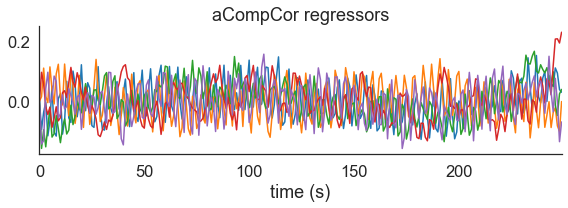

In [5]:
# Extract aCompCor signals from confounds table
acompcor_n = 5
acompcor_df = confounds.filter(regex='aCompCor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values

# Plot aCompCor regressors
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, acompcor)
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)', 
       title='aCompCor regressors')
sns.despine()
plt.tight_layout()

#### Assemble confound regressors

In this final step, we column-stack our nuisance regressors into one confound matrix. We also include an intercept term.

In [6]:
# Define intercept
intercept = np.ones(n_acq)

# Stack nuisance regressors
Z = np.column_stack([intercept, motion, censors, acompcor])

# Keep track of confound labels
confound_labels = ['intercept'] + motion_labels + censor_labels + acompcor_labels

### Step 3: Check collinearity

In this optional step, we check the collinearity of our full design matrix. Collinearity is a condition in which some of the independent variables are highly correlated. Collinearity tends to create numerical instability in our regression and inflate the variance of the estimated regression coefficients. To check collinearity, we rely on the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor). As a simple rule of thumb, VIF scores above 5 suggest problematic collinearity. VIF scores below 5 are usually ok. We'll use Python's `statsmodels` package to inspect collinearity; if you don't have `statsmodels` installed, go to the command line, make sure your conda environment is activated, and run the following line: `conda install -c conda-forge statsmodels`.

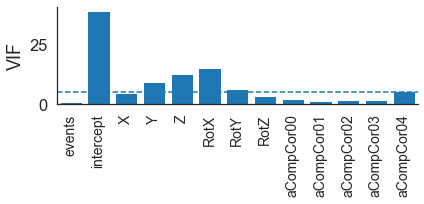

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assemble all regressors (experimental + confound)
XZ = np.column_stack([X, Z])

# Assemble all regressor labels
regressor_labels = ['events'] + confound_labels

# Check variance inflation factor
vif = [variance_inflation_factor(XZ, i) for i in range(XZ.shape[-1])]

# Visualize collinearity
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.bar(np.arange(len(vif)), vif)
ax.hlines(5,-0.5,len(vif)-0.5,linestyle='--')
ax.set(xlim=(-0.5,len(vif)-0.5), xticks=np.arange(len(vif)), 
       ylabel='VIF')
ax.set_xticklabels(regressor_labels, rotation=90, fontsize=14)
sns.despine()
plt.tight_layout()

### Step 4: Prepare fMRI Data

In this next step, we prepare the fMRI data for regression analysis. In this demo, we are only analyzing one brain slice. The steps below are then for whole-brain.

#### Load and mask data

Here we load the functional data and the anatomical segmentation (aseg). We mask the functional data only to voxels inside the cortex. After masking, we reshape the data to [n_times, n_voxels].

In [8]:
import nibabel as nib

# Load one slice of functional data
bold_f = 'sub-01_task-visualcontrol_space-T1w_desc-preproc_bold.nii.gz'
bold_img = nib.load(bold_f)
bold = bold_img.get_fdata()
print(f'Functional data shape: {bold.shape}')

# Load anatomical segmentation
f = 'sub-01_task-visualcontrol_space-T1w_desc-aseg_dseg.nii.gz'
aseg = nib.load(f).get_fdata()
print(f'Segmentation shape: {aseg.shape}')

# Store dimensions of anatomical image
brain_shape = aseg.shape

# Store indices corresponding to gray matter mask
mask_img = nib.Nifti1Image(np.logical_or(aseg == 3,     # left cortex
                                         aseg == 42).astype(float),
                           affine=bold_img.affine)    # right cortex
mask_indices = np.where(np.logical_or(aseg == 3,    # left cortex
                                      aseg == 42    # right cortex
                                      ))

# Apply gray matter mask
bold_masked = bold[mask_indices]

# Transpose data to shape (n_times, n_voxels)
Y = bold_masked.T
print(f'Masked data shape: {Y.shape}')

Functional data shape: (50, 59, 1, 250)
Segmentation shape: (50, 59, 1)
Masked data shape: (250, 661)


### Step 5: Regression
Using ordinary least squares (OLS) regression, we regress our design matrix against the observed BOLD data (including nuisance regressors to reduce noise). Using the indices from the anatomical segmentation, we then extract the regression coefficients ($\beta$-coefficients) and store them in new maps.

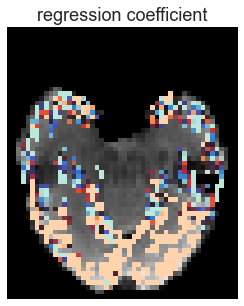

In [10]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(XZ, Y, rcond=-1)

# Make beta coefficient brain map
beta_map = np.zeros_like(aseg)
beta_map[mask_indices] = b[0]

beta_viz = beta_map[:,::-1].T.squeeze().copy()
beta_viz = np.where(np.abs(beta_viz) > 1, beta_viz, np.nan)

# Load BOLD reference for visualization
boldref_f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'
boldref = nib.load(boldref_f).get_fdata()
boldref = boldref[:,::-1].T.squeeze()

# Plot regression coefficient (beta)
fig, ax = plt.subplots(1, 1,figsize=(12, 5))
sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
            xticklabels=[], yticklabels=[], ax=ax)
sns.heatmap(beta_viz, center=0, square=True, vmin=-20, vmax=20,
            xticklabels=[], yticklabels=[], ax=ax, cbar=False)
ax.set(title='regression coefficient')
plt.show()

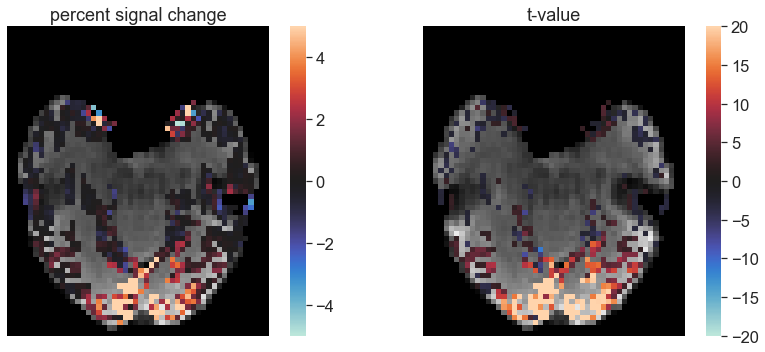

In [11]:
from nilearn.signal import clean
from fmritools.stats import OLS

# Filter the data
high_pass = 1/128
Y = clean(Y, detrend=True, high_pass=high_pass, standardize='psc', t_r=tr)

# Fit OLS model
fit = OLS(Y, X, Z).fit()

# Make percent signal change maps
psc_map = np.zeros_like(aseg)
psc_map[mask_indices] = fit.coef

# Make t-statistic maps
t_map = np.zeros_like(aseg)
t_map[mask_indices] = fit.tvalues

# Visualize (before multiple comparisons)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Make copies for visualization
psc_viz = psc_map[:,::-1].T.squeeze().copy()
psc_viz = np.where(np.abs(psc_viz) > 0, psc_viz, np.nan)
t_viz = t_map[:,::-1].T.squeeze().copy()
t_viz = np.where(np.abs(t_viz) > 1.96, t_viz, np.nan)

# Plot percent signal change
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax = sns.heatmap(psc_viz, center=0, vmin=-5, vmax=5, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax.set(title='percent signal change')

# Plot t-statistics
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax = sns.heatmap(t_viz, center=0, vmin=-20, vmax=20, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax.set(title='t-value')
plt.tight_layout()

#### Correction for multiple tests
Next correct for multiple tests by controlling the false discovery rate (FDR; Benjamini-Hochberg procedure). We'll use the FDR implementation from `statsmodels`.

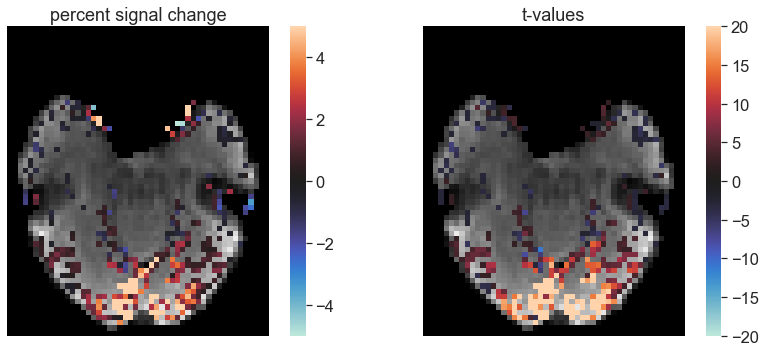

In [12]:
from statsmodels.stats.multitest import multipletests

# Extract p-values
p_values = fit.pvalues

# Perform correction
_, q_values, _, _ = multipletests(p_values[0], method='fdr_bh')

# Make q-value maps
q_map = np.zeros_like(aseg)
q_map[mask_indices] = q_values

# Mask PSC map
psc_map_thresh = psc_map.copy()
psc_map_thresh[q_map > 0.05] = 0

# Mask T-map
t_map_thresh = t_map.copy()
t_map_thresh[q_map > 0.05] = 0

# Visualization results after correction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Load BOLD reference
boldref_f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'
boldref = nib.load(boldref_f).get_fdata()
boldref = boldref[:,::-1].T.squeeze()

# Make copies for visualization
psc_viz = psc_map_thresh[:, ::-1].T.squeeze().copy()
psc_viz = np.where(np.abs(psc_viz) > 0, psc_viz, np.nan)
t_viz = t_map_thresh[:, ::-1].T.squeeze().copy()
t_viz = np.where(np.abs(t_viz) > 0, t_viz, np.nan)

# Plot percent signal change
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax = sns.heatmap(psc_viz, center=0, vmin=-5, vmax=5, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax.set(title='percent signal change')

# Plot t-statistics
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax = sns.heatmap(t_viz, center=0, vmin=-20, vmax=20, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax.set(title='t-values')
plt.tight_layout()